In [2]:
!pip install pyspark

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
from pyspark.sql import SparkSession

# Создание SparkSession
spark = SparkSession.builder \
    .appName("Quality Analysis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

# Установка количества разделов для shuffle операций
spark.conf.set("spark.sql.shuffle.partitions", "50")

# Чтение данных из HDFS
file_path = "hdfs://localhost:9000/userrus/quality.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Просмотр первых строк данных
df.show(5)

+----------+-------------+---------+--------+
|product_id| manufacturer|  quality|batch_id|
+----------+-------------+---------+--------+
|         1|ManufacturerS|     Good|     176|
|         2|ManufacturerD|Defective|     196|
|         3|ManufacturerI|Defective|     178|
|         4|ManufacturerS|     Good|     132|
|         5|ManufacturerM|     Good|     152|
+----------+-------------+---------+--------+
only showing top 5 rows



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Создание SparkSession
spark = SparkSession.builder \
    .appName("Quality Analysis - Problematic Products") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

# Чтение данных из HDFS
file_path = "hdfs://localhost:9000/userrus/quality.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Фильтрация проблемных товаров (качество = "Defective")
problematic_products = df.filter(col("quality") == "Defective")

# Вывод проблемных товаров
problematic_products.show()

# Сохранение результатов в HDFS
output_path_problematic = "hdfs://localhost:9000/userrus/problematic_products"
problematic_products.write.csv(output_path_problematic, header=True)

# Закрытие SparkSession
spark.stop()

+----------+-------------+---------+--------+
|product_id| manufacturer|  quality|batch_id|
+----------+-------------+---------+--------+
|         2|ManufacturerD|Defective|     196|
|         3|ManufacturerI|Defective|     178|
|         8|ManufacturerM|Defective|     156|
|        10|ManufacturerI|Defective|     132|
|        12|ManufacturerG|Defective|     130|
|        13|ManufacturerU|Defective|     155|
|        14|ManufacturerH|Defective|     181|
|        15|ManufacturerL|Defective|     103|
|        17|ManufacturerH|Defective|     196|
|        18|ManufacturerV|Defective|     122|
|        21|ManufacturerO|Defective|     106|
|        22|ManufacturerV|Defective|     167|
|        23|ManufacturerJ|Defective|     186|
|        24|ManufacturerH|Defective|     176|
|        25|ManufacturerA|Defective|     122|
|        26|ManufacturerM|Defective|     183|
|        30|ManufacturerP|Defective|     176|
|        32|ManufacturerL|Defective|     174|
|        33|ManufacturerP|Defectiv

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum as spark_sum

# Создание SparkSession
spark = SparkSession.builder \
    .appName("Quality Analysis - Defect Percentage") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

# Чтение данных из HDFS
file_path = "hdfs://localhost:9000/userrus/quality.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Группировка данных по производителю и расчет процента брака
defect_percentage_df = df.groupBy("manufacturer") \
    .agg(
        spark_sum(when(col("quality") == "Defective", 1).otherwise(0)).alias("defective_count"),
        spark_sum(when(col("quality").isNotNull(), 1).otherwise(0)).alias("total_count")
    ) \
    .withColumn("defect_percentage", (col("defective_count") / col("total_count") * 100).cast("double"))

# Вывод результатов
defect_percentage_df.show()

# Сохранение результатов в HDFS
output_path_defect = "hdfs://localhost:9000/userrus/defect_percentage"
defect_percentage_df.write.csv(output_path_defect, header=True)

# Закрытие SparkSession
spark.stop()

25/05/03 04:28:07 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-------------+---------------+-----------+------------------+
| manufacturer|defective_count|total_count| defect_percentage|
+-------------+---------------+-----------+------------------+
|ManufacturerP|             22|         35|62.857142857142854|
|ManufacturerK|             21|         41| 51.21951219512195|
|ManufacturerM|             22|         41| 53.65853658536586|
|ManufacturerQ|             14|         37| 37.83783783783784|
|ManufacturerT|             24|         45|53.333333333333336|
|ManufacturerR|             24|         43| 55.81395348837209|
|ManufacturerS|             24|         43| 55.81395348837209|
|ManufacturerH|             21|         35|              60.0|
|ManufacturerI|             23|         50|              46.0|
|ManufacturerE|             17|         34|              50.0|
|ManufacturerZ|             13|         28| 46.42857142857143|
|ManufacturerU|             17|         40|              42.5|
|ManufacturerD|             24|         48|            

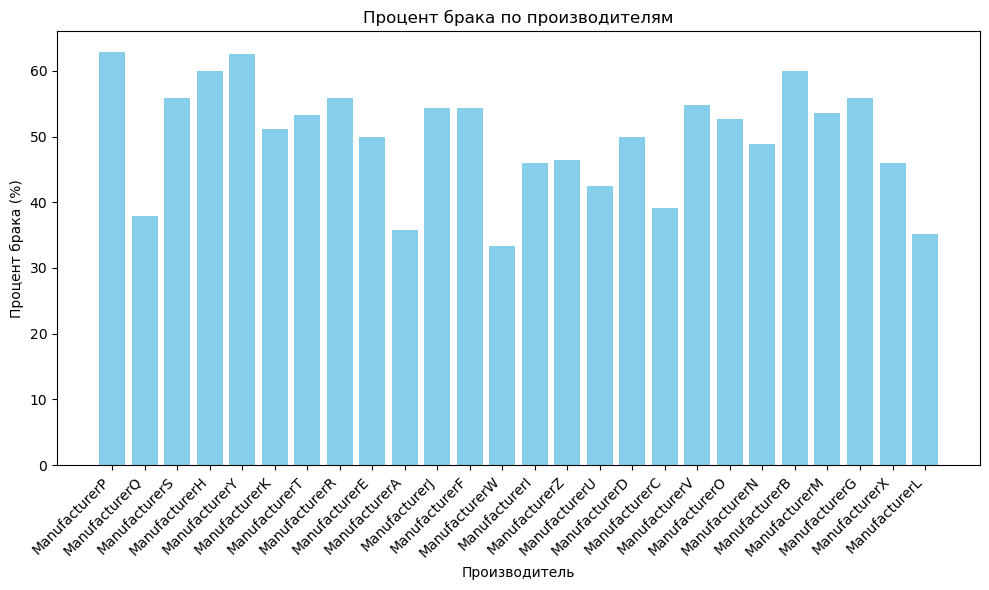

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum as spark_sum

# Создание SparkSession
spark = SparkSession.builder \
    .appName("Quality Analysis - Visualization") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

# Чтение данных из HDFS (исходный датасет)
file_path = "hdfs://localhost:9000/userrus/quality.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Группировка данных по производителю и расчет процента брака
defect_percentage_df = df.groupBy("manufacturer") \
    .agg(
        spark_sum(when(col("quality") == "Defective", 1).otherwise(0)).alias("defective_count"),
        spark_sum(when(col("quality").isNotNull(), 1).otherwise(0)).alias("total_count")
    ) \
    .withColumn("defect_percentage", (col("defective_count") / col("total_count") * 100).cast("double"))

# Преобразование Spark DataFrame в Pandas DataFrame
pandas_df = defect_percentage_df.toPandas()

# Построение диаграммы
plt.figure(figsize=(10, 6))
plt.bar(pandas_df['manufacturer'], pandas_df['defect_percentage'], color='skyblue')
plt.xlabel('Производитель')
plt.ylabel('Процент брака (%)')
plt.title('Процент брака по производителям')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Сохранение диаграммы в файл
plt.savefig('defect_percentage_chart.png')

# Отображение диаграммы
plt.show()

# Закрытие SparkSession
spark.stop()